In [1]:
%run init_notebookspace.py

In [2]:
import numpy as np
import pandas as pd
import scipy.stats as scs
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm
from src.helpers_plot import get_ndf_plot
from src.utils import run_parallel_wrap
from advanced_econ import *

In [3]:
import os
path = os.path.abspath("C://Users//au782406//Downloads//advanced econ")

## Question 5

In [4]:
T = 5_000
X0 = 0
alpha = .5
mu = 2
sigma = 1

In [5]:
Xt_mu = get_Xt(X0, alpha, mu, sigma, T)
XT_hat = lambda T: 1/T * np.sum(Xt_mu[:T])
XT_hat_std = lambda T: np.std(Xt_mu[:T])

### a)

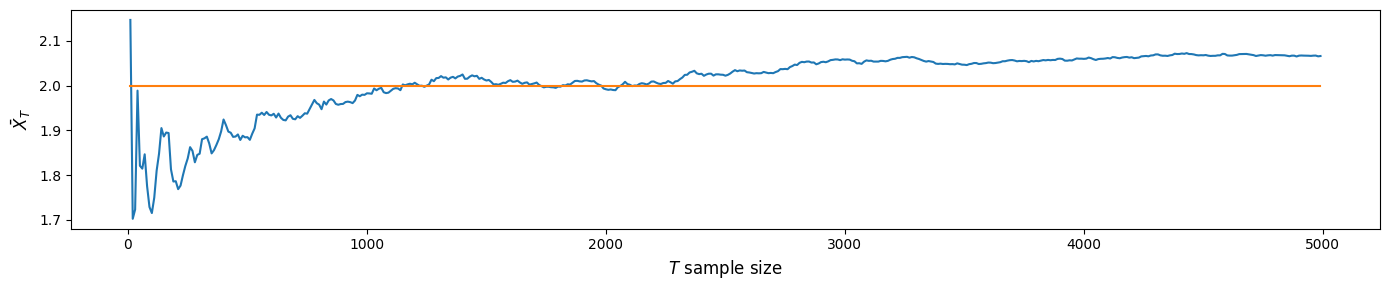

In [6]:
lst_x = range(10, 5_000, 10)
mean = np.array([XT_hat(i) for i in lst_x])
std = np.array([XT_hat_std(i) for i in lst_x])

plt.plot(lst_x, mean)
plt.plot(lst_x, [mu] * len(mean))
plt.ylabel("$\\bar{X}_T$", size=12)
plt.xlabel("$T$ sample size", size=12)
plt.tight_layout()

C:\Users\au782406\Documents\GIT\ambg_announcement\notebooks\..\src\helpers_plot.py:34: UserWarning: pd.DataFrames are not equivalent
  warnings.warn("pd.DataFrames are not equivalent")


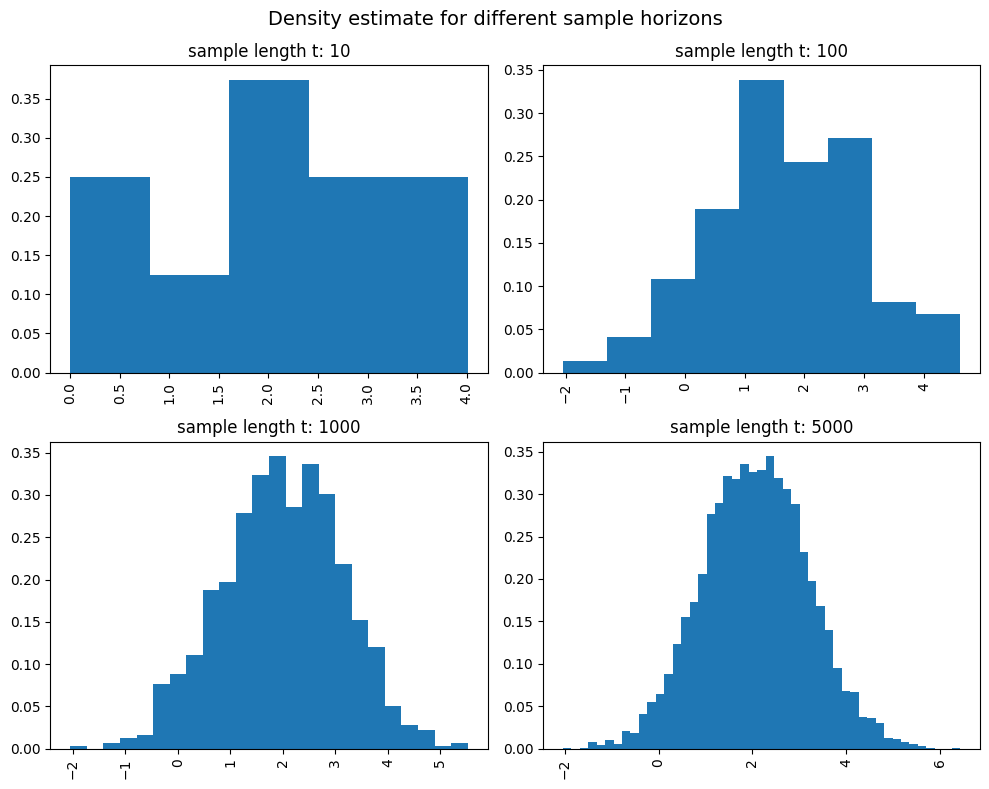

In [7]:
lst = [10, 100, 1000, 5_000]
dct = {f'sample length t: {t}' : pd.DataFrame(Xt_mu[:t], columns=['Xt']) for t in lst}
fig, ax = get_ndf_plot(dct, plot_func=lambda arr, ax: ax.hist(arr, bins='fd', density=True), is_equalise_axis=False, n_cols=2, length_col=5, length_row=4)
fig.suptitle('Density estimate for different sample horizons', size=14)
fig.tight_layout()
fig.savefig(os.path.join(path, "5a.png"))

### b)

In [8]:
M = 10_000
T = 1_000
arr_Xt_montC = np.zeros((M, T))
arr_mu_montC = np.zeros(M)[:,None]

# lst_dct_arguments = [{'X0': X0, 'alpha': alpha, 'mu': scs.norm(mu, 1).rvs(), 'sigma': sigma, 'T': T} for _ in range(M)]
lst_dct_arguments = [{'X0': X0, 'alpha': alpha, 'mu': mu, 'sigma': sigma, 'T': T} for _ in range(M)]
res = run_parallel_wrap(get_monte_carlo_5, lst_dct_arguments, n_process=6)


00%|███████████████████████████████████████████████████████████████████████████████████| 10000/10000 [15:38<00:00, 10.66it/s]

In [12]:
arr_Xt_montC = np.array([i[0] for i in res])
arr_mu_montC = np.array([i[1] for i in res])[:,None]

### d)

estimates for b)

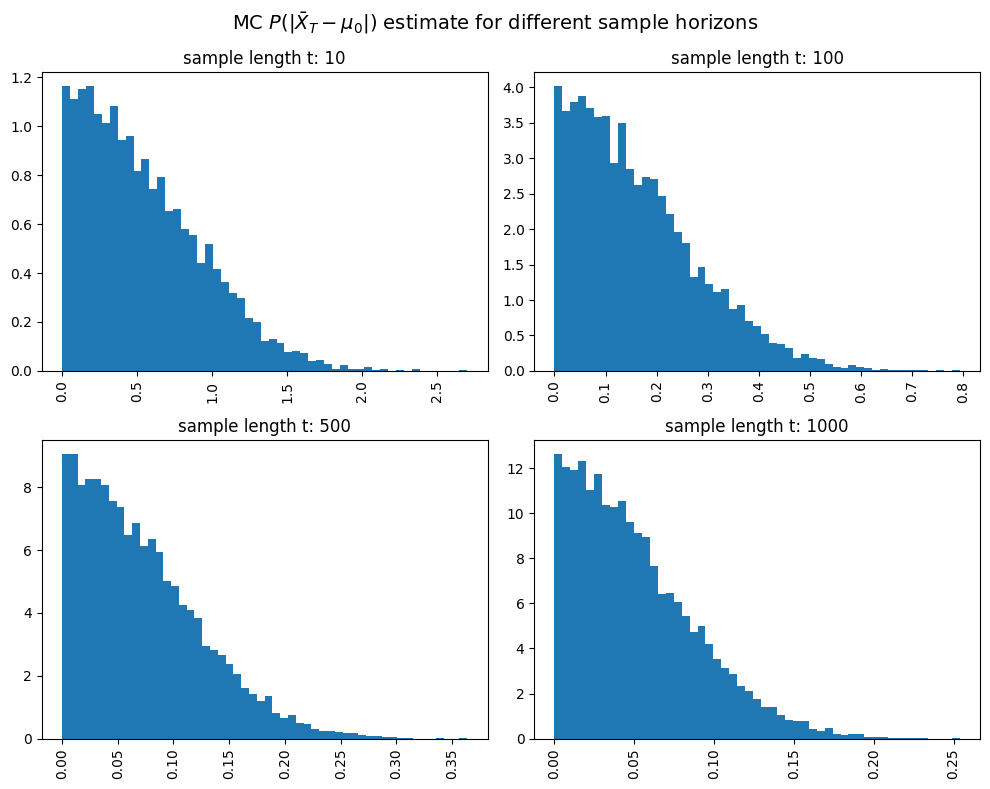

In [59]:
lst = [10, 100, 500, 1000,]
dct = {
    f'sample length t: {t}' : pd.DataFrame(
        np.abs(arr_Xt_montC[:,:t].mean(axis=1)[:,None] - arr_mu_montC),
        columns=['MC t']
    )
    for t in lst
}
fig, ax = get_ndf_plot(dct, plot_func=lambda arr, ax: ax.hist(arr, bins='fd', density=True), is_equalise_axis=False, n_cols=2, length_col=5, length_row=4)
fig.suptitle('MC $P(|\\bar{X}_T - \\mu_0|)$ estimate for different sample horizons', size=14)
fig.tight_layout()
fig.savefig(os.path.join(path, "5d_b.png"))

estimates for c)

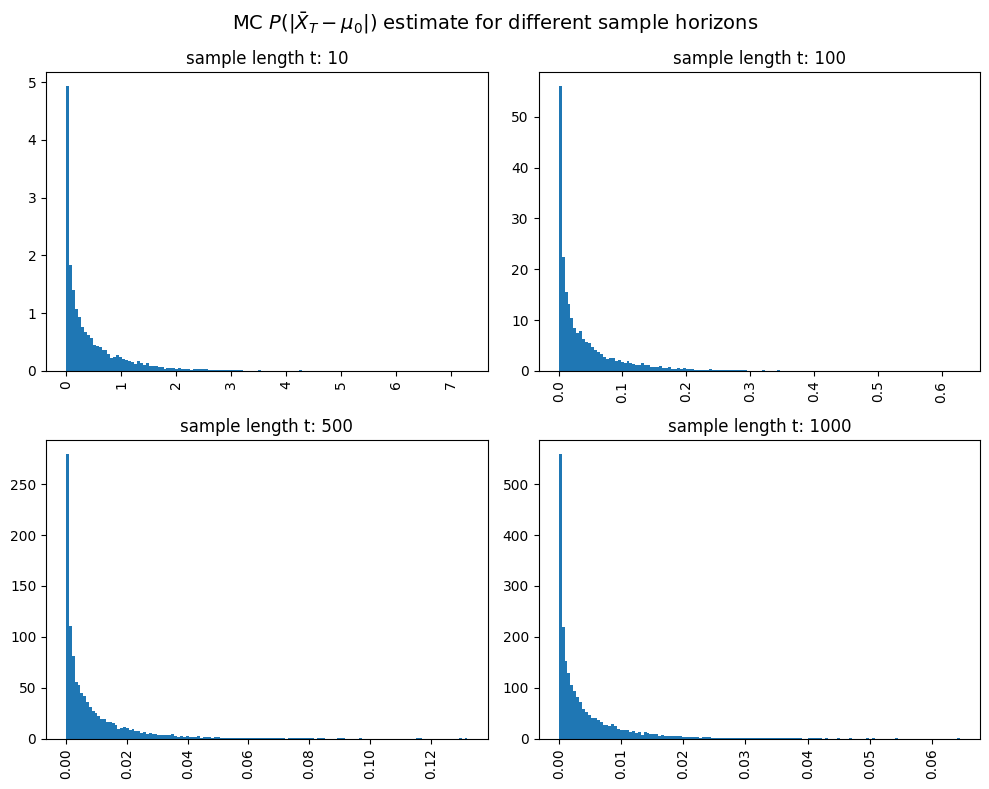

In [60]:
lst = [10, 100, 500, 1000,]
dct = {
    f'sample length t: {t}' : pd.DataFrame(
        (arr_Xt_montC[:,:t].mean(axis=1)[:,None] - arr_mu_montC) ** 2,
        columns=['MC t']
    )
    for t in lst
}
fig, ax = get_ndf_plot(dct, plot_func=lambda arr, ax: ax.hist(arr, bins='fd', density=True), is_equalise_axis=False, n_cols=2, length_col=5, length_row=4)
fig.suptitle('MC $P(|\\bar{X}_T - \\mu_0|)$ estimate for different sample horizons', size=14)
fig.tight_layout()
fig.savefig(os.path.join(path, "5d_c.png"))

## Question 7

In [48]:
X0 = 0
alpha = .1

In [49]:
def get_Xt_7(X0, alpha, epsilon, T=500):
    Xt = np.zeros(T)[:,None]
    Xt[0] = X0
    for i in range(1,T):
        Xt[i] = alpha * Xt[i-1] + epsilon.rvs()
    return Xt

### b)

In [50]:
epsilon_mu = 0
epsilon_sigma = 1

dist_epsilon = scs.norm(epsilon_mu, epsilon_sigma)

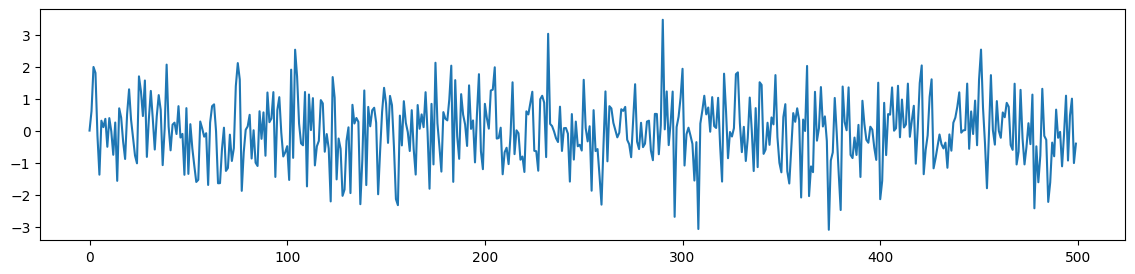

In [51]:
Xt = get_Xt_7(X0, alpha, epsilon=dist_epsilon)
plt.plot(Xt)

### c)

In [52]:
epsilon_lambda = 1

dist_epsilon = scs.expon(epsilon_sigma)

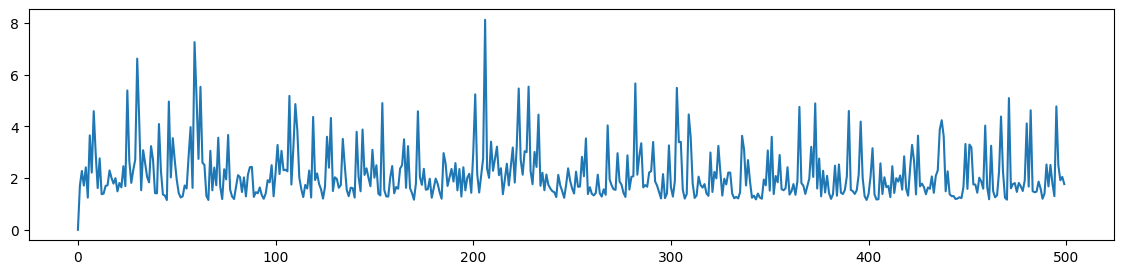

In [53]:
Xt = get_Xt_7(X0, alpha, epsilon=dist_epsilon)
plt.plot(Xt)